In [15]:
#Import necissary modules and supress warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os
#List directories of the image data
print(os.listdir("../Images/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/"))

['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']


In [16]:
# Load medium sized color image data (28 x 28 px)
medium_size_colored_data = pd.read_csv('../Images/hmnist_28_28_RGB.csv')
medium_size_colored_data.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,156,73,106,169,79,115,199,131,161,190,...,148,67,117,191,102,148,199,137,172,2
1,139,33,55,139,32,58,143,35,52,159,...,159,39,65,155,38,59,148,38,60,2
2,186,96,135,193,108,148,176,91,137,189,...,227,175,199,195,120,158,155,66,108,2
3,139,50,84,158,55,93,185,61,88,188,...,206,79,110,160,48,73,117,34,63,2
4,197,130,162,182,119,155,171,93,135,181,...,204,180,201,190,126,162,198,132,165,2
5,172,92,135,152,73,123,119,59,114,104,...,185,115,168,174,108,160,162,77,125,2
6,212,173,199,212,173,197,213,176,196,220,...,166,101,143,192,143,170,223,198,214,2
7,112,50,91,158,67,106,189,95,129,209,...,208,150,174,145,96,130,131,67,103,2
8,177,97,132,185,104,140,188,100,136,189,...,204,112,145,214,128,158,197,107,143,2
9,191,115,149,209,159,185,206,151,183,211,...,191,100,139,187,100,131,189,102,132,2


Text(0, 0.5, 'Height')

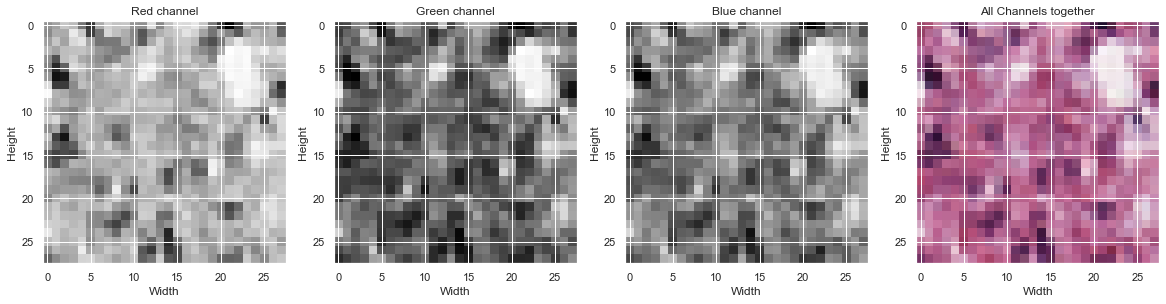

In [17]:
#Cleaning data by removing unnecissary column "label" from the .csv file.
example = medium_size_colored_data.drop("label", axis=1).values[0]
data_to_show = example.reshape((28,28,3))

#Each image is in RGB format.
colors = ["Red", "Green", "Blue"]

#Plots an image with each color channel shown seperately. 
fig, ax = plt.subplots(1,4,figsize=(20,5))
for channel in range(3):
    ax[channel].imshow(data_to_show[:,:, channel], cmap="gray")
    ax[channel].set_title("{} channel".format(colors[channel]))
    ax[channel].set_xlabel("Width")
    ax[channel].set_ylabel("Height")
ax[3].imshow(data_to_show)
ax[3].set_title("All Channels together")
ax[3].set_xlabel("Width")
ax[3].set_ylabel("Height")
            

In [ ]:
#Define tissue classes for graph labeling
class_names = {1: "Tumor", 2: "Stroma", 3: "Complex", 4: "Lympho",
               5: "Debris", 6: "Mucosa", 7: "Adipose", 8: "Empty"}
#Assign colors to each graph.
class_colors = {1: "Red", 2: "Orange", 3: "Gold", 4: "Limegreen",
                5: "Mediumseagreen", 6: "Darkturquoise", 7: "Steelblue", 8: "Purple"}

#Select medium colored data to display
images = medium_size_colored_data

#Graph image intensity for each catagory of images
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,4, figsize=(25,11))
for n in range(2):
    for m in range(4):
        class_idx = n*4+(m+1)
        sns.distplot(images[images.label == class_idx].drop("label", axis=1).values.flatten(),
                     ax=ax[n,m],
                     color=class_colors[class_idx])
        ax[n,m].set_title(class_names[class_idx])
        ax[n,m].set_xlabel("Intensity")
        ax[n,m].set_ylabel("Density")

In [ ]:
#Read 10 sample images from each category and generate a statistical mean based on those images.
image_statistics = pd.DataFrame(index=images.index)
image_statistics["Mode"] = images.apply(lambda l: stats.mode(l)[0][0], axis=1)
for q in range(1, 10):
    col_name = "Q" + str(q*10)
    image_statistics[col_name] = images.apply(lambda l: np.quantile(l, (q*10)/100), axis=1)

#Plots the mean image intensity of all 8 catagories overlayed with their distrobution.
image_statistics["label"] = images.label.values
image_statistics.head()
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,4, figsize=(25,11))
for n in range(2):
    for m in range(4):
        class_idx = n*4+(m+1)
        sns.distplot(images[images.label == class_idx].drop("label", axis=1).values.flatten(),
                     ax=ax[n,m],
                     color=class_colors[class_idx], 
                     norm_hist=True,
                     bins=50)
        sns.distplot(image_statistics[image_statistics.label == class_idx]["Mode"].values,
                     ax=ax[n,m],
                     color="lightskyblue",
                     norm_hist=True, 
                     bins=50)
        ax[n,m].set_title(class_names[class_idx])
        ax[n,m].set_xlabel("Intensity")
        ax[n,m].set_ylabel("Density")

In [ ]:
#Use a Gaussian mixture model to cluster image catagories according to similarity

scaler = StandardScaler()
X = scaler.fit_transform(image_statistics.drop("label", axis=1).values)
y = image_statistics.label.values

model = GaussianMixture(n_components=8,
                        covariance_type="full",
                        n_init=10,
                        random_state=0)

cluster = model.fit_predict(X)
image_statistics["cluster"] = cluster

counts = image_statistics.groupby("label").cluster.value_counts()
counts = counts.unstack()
counts.fillna(0, inplace=True)

sns.set()
plt.figure(figsize=(20,6))

for n in range(8):
    for m in range(1,9):
        plt.scatter(n, m, s=counts.loc[m,n], color=class_colors[m])
plt.xlabel("Cluster")
plt.yticks(np.arange(1,9), [class_names[label] for label in list(np.arange(1,9))]);
plt.title("Tissue Categorys clustered by similarity");